In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import glob
import random
from sklearn import model_selection

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from keras import backend as K
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from itertools import chain, repeat, cycle


import os
import shutil
%matplotlib inline

Using TensorFlow backend.


In [2]:
import re
import collections


DATA_DIR = "./rename"
TRAIN_DIR = "./train"
VAL_DIR = "./val"
validation_percentage = 10
MAX_NUM_IMAGES_PER_CLASS = 2 ** 27 - 1
result = collections.OrderedDict()
sub_dirs = sorted(x[0] for x in os.walk('./'))
print('Found directory: %s' % sub_dirs)

Found directory: ['./', './.ipynb_checkpoints', './bottleneck', './bottleneck/Coats_Outerwear', './bottleneck/Dresses', './bottleneck/Jeans', './bottleneck/Pants', './bottleneck/Shirts_Tops', './bottleneck/Sleepwear', './bottleneck/Sweaters', './bottleneck/Swimwear', './bottleneck/Underwear', './bottleneck/Underwear_Intimates', './category', './category/Coats_Outerwear', './category/Dresses', './category/Jeans', './category/Pants', './category/Shirts_Tops', './category/Sleepwear', './category/Sweaters', './category/Swimwear', './category/Underwear', './category/Underwear_Intimates', './logs', './rename', './tf_files', './train', './training_summaries', './training_summaries/train', './training_summaries/validation', './val']


In [67]:
import hashlib

extensions = ['jpg', 'jpeg', 'JPG', 'JPEG']
file_list = []
for extension in extensions:
    file_glob = os.path.join(DATA_DIR, '*.' + extension)
    file_list.extend( glob.glob(file_glob))    
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    training_images = []
    testing_images = []
    validation_images = []    
    for file_name in file_list:
        base_name = os.path.basename(file_name)
        hash_name = re.sub(r'_nohash_.*$', '', file_name)
        hash_name_hashed = hashlib.sha1(str.encode(hash_name)).hexdigest()

        percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_IMAGES_PER_CLASS))
        #print(percentage_hash)  
        if percentage_hash < validation_percentage:
            validation_images.append(base_name)   
        else:
            training_images.append(base_name)
        result[label_name] = {
            'dir': dir_name,
            'training': training_images,
            #'testing': testing_images,
            'validation': validation_images,
        }

NameError: name 'dir_name' is not defined

In [4]:
print(len(training_images), len(validation_images))

NameError: name 'training_images' is not defined

In [3]:
NUM_TRAIN_EXAMPLES = 0
NUM_VAL_EXAMPLES = 0

if not os.path.exists(TRAIN_DIR) or  not os.path.exists(VAL_DIR):
    data = glob.glob(DATA_DIR + "/*.jpg")
    print("creating data directories for training and validation")
    train, val = model_selection.train_test_split(data, test_size=0.1)
    os.makedirs(TRAIN_DIR)
    os.makedirs(VAL_DIR)

    for e in train:
        shutil.copy(e, TRAIN_DIR + "/" + e.split("/")[-1] )
    for e in val:
        shutil.copy(e, VAL_DIR + "/" + e.split("/")[-1] )
else:
    print("directories already exist")
    NUM_TRAIN_EXAMPLES = len(glob.glob(TRAIN_DIR+"/*.jpg"))
    print("Train:", NUM_TRAIN_EXAMPLES )
    NUM_VAL_EXAMPLES = len(glob.glob(VAL_DIR+"/*.jpg"))
    print("Validation:",NUM_VAL_EXAMPLES )

directories already exist
Train: 145134
Validation: 16126


In [4]:
inception_model = InceptionV3(weights='imagenet', include_top=False)


In [5]:
img_width, img_height = 256, 256
batch_size = 32

top_layers_checkpoint_path = './model/cp.top.best.hdf5'
fine_tuned_checkpoint_path = './model/cp.fine_tuned.best.hdf5'
new_extended_inception_weights = './model/final_weights.hdf5'

x = inception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='tanh')(x)
prediction = Dense(264, activation='sigmoid')(x)

model = Model(input=inception_model.input, output=prediction)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print ("Checkpoint '" + top_layers_checkpoint_path + "' loaded.")

"""
Freeze all inception layers
"""
for layer in inception_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [6]:
import pandas as pd
mvc_attribute = pd.read_csv( './mvc_attribute_all.csv', index_col='filename')

In [7]:
mvc_attribute.index=mvc_attribute.index.map(lambda x:x + '.jpg')

In [8]:
mvc_attribute.tail(10)

,AlineDresses,AnimalPrint,Anoraks,Argyle,Asymmetrical,Athletic,BabyDollDresses,BalconetteBras,Bandeau,BandeauBras,...,Yellow,ZebraPrint,Zipper,fiftyU,halfZip,hundred1U,hundred2O,hundred2U,quarter3Zip,quarterZip
filename,,,,,,,,,,,,,,,,,,,,,
p8691908_s3531907_v4.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
p8691908_s3531913_v0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
p8691908_s3531913_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
p8691908_s3531913_v2.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
p8691908_s3531913_v3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
p8691908_s3531913_v4.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
p8699425_s3548654_v0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p8699425_s3548654_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p8699425_s3548654_v2.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [18]:
mvc_attribute.to_csv('./mvc_label.csv')

In [19]:
mvc_label = pd.read_csv( './mvc_label.csv', index_col='filename')
mvc_label.head(10)

,AlineDresses,AnimalPrint,Anoraks,Argyle,Asymmetrical,Athletic,BabyDollDresses,BalconetteBras,Bandeau,BandeauBras,...,Yellow,ZebraPrint,Zipper,fiftyU,halfZip,hundred1U,hundred2O,hundred2U,quarter3Zip,quarterZip
filename,,,,,,,,,,,,,,,,,,,,,
p7258521_s3163710_v0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v2.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163710_v4.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v0.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v1.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v2.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
p7258521_s3163713_v3.jpg,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
def grouper(n, iterable, padvalue=None):
    g = cycle(zip(*[chain(iterable, repeat(padvalue, n-1))]*n))
    for batch in g:
        yield list(filter(None, batch))
 
 
def multilabel_flow(path_to_data, idg, bs=256, target_size=(256,256), train_or_valid='train', shuffle=False):
    gen = idg.flow_from_directory(path_to_data, batch_size=bs, target_size=target_size, classes=[train_or_valid],shuffle=shuffle)
    names_generator = grouper(bs, gen.filenames)
    #print(gen.filenames)
    for (X_batch, _), names in zip(gen, names_generator):
    #    print(names)
        labels = [ mvc_attribute.loc[n.split('/')[-1]] for n in names ]
        targets = np.array(labels)
        yield X_batch, targets

In [14]:
train_gen = image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.3,
    channel_shift_range=0.3,
    horizontal_flip=True)

test_gen = image.ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = multilabel_flow(
                    './',
                    train_gen,
                    bs=batch_size,
                    target_size=(img_height, img_width),
                    train_or_valid='train',shuffle=True)

validation_generator = multilabel_flow(
                    './',
                    test_gen,
                    bs=batch_size,
                    target_size=(img_height, img_width),
                    train_or_valid='val', shuffle=True)

Found 145134 images belonging to 1 classes.


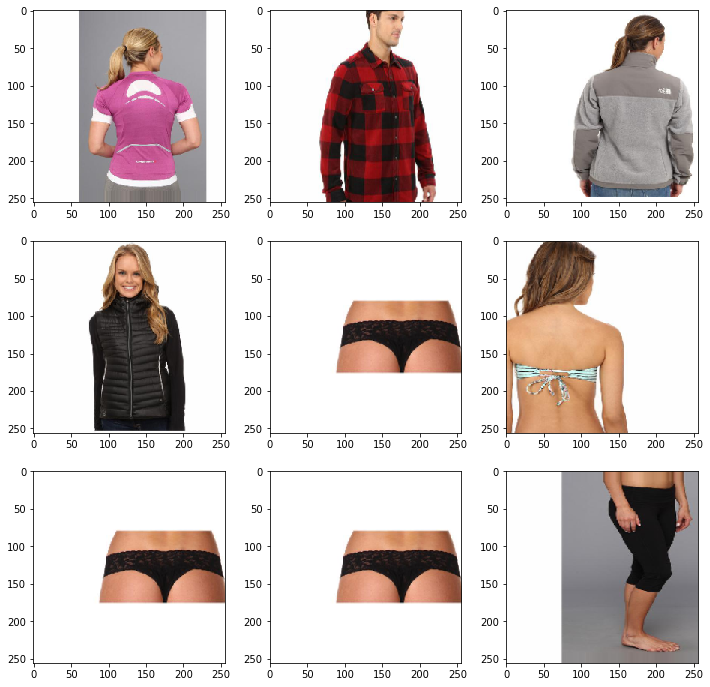

In [16]:
samples = next(train_generator)
fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
for i in range(9):
    draws[i].imshow(samples[0][random.randint(0, 23)])

In [17]:
tb = TensorBoard(log_dir='./logs', write_graph=True)
mc_top = ModelCheckpoint(top_layers_checkpoint_path,
                         monitor='val_acc', verbose=0,
                         save_best_only=True,
                         save_weights_only=False,
                         mode='auto', period=1)
top_epochs = 5

model.fit_generator(train_generator, steps_per_epoch=NUM_TRAIN_EXAMPLES//batch_size,
         nb_epoch=top_epochs, validation_data=validation_generator,
         validation_steps=NUM_VAL_EXAMPLES//batch_size,
         callbacks=[mc_top, tb], use_multiprocessing=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=4535, validation_data=<generator..., validation_steps=503, callbacks=[<keras.ca..., use_multiprocessing=True, epochs=5)`
  if sys.path[0] == '':


Found 16126 images belonging to 1 classes.
Epoch 1/5
 421/4535 [=>............................] - ETA: 4:58:55 - loss: 0.1043 - acc: 0.9729

Process Process-2:
Traceback (most recent call last):
Process Process-4:
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
    time.sleep(self.wait_time)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
    time.sleep(self.wait_time)
KeyboardInterrupt


KeyboardInterrupt: 